In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import astropy.coordinates as coord
import astropy.units as u
from pathlib import Path

from csaps import csaps
from scipy import interpolate

# Constants

deg2rad = np.pi/180

Gr = 6.6740831E-11      # (m/s^2) * (m^2/kg)
Ms = 1.988489E+30       # kg
yr = 31556925.2         # sec
pc = 3.08567758149E+16  # m

ka    = pc/60**2 * np.pi/180/1e3/yr/1000  # mas/yr*pc -> km/s
V_vir = np.sqrt( Gr * Ms / pc)/1000       # virial velocity, km/s

In [2]:
# King's cumulative profile

def n_king(r, k, rc, rt):
    
    ar1 = (r/rc)**2
    ar2 = 1 + ar1
    ar3 = np.sqrt( ar2 )
    at1 = 1 + (rt/rc)**2
    at2 = np.sqrt( at1 )    
    n_cum = np.pi * rc**2 * k * ( np.log(ar2) - 4*(ar3-1)/at2 + ar1/at1)
        
    return n_cum

In [3]:
cluster = pd.read_csv(r'../Data/to_0343_NGC_1502m', delimiter='\s+', skiprows=3)
# cluster.keys()

In [4]:
head = pd.read_csv(r'../Data/to_0343_NGC_1502m', delimiter='\s+', nrows=1)
# head.keys()

In [5]:
# Reading Data

alpha = cluster['ahour'].to_numpy() * 15 * deg2rad
delta = cluster['ddeg'].to_numpy() * deg2rad

pmx  = cluster['pmx'].to_numpy()
pmy  = cluster['pmy'].to_numpy()
pjk  = cluster['pjk'].to_numpy()
pjh  = cluster['pjh'].to_numpy()
kmag = cluster['kmag'].to_numpy()

distance = head['dist'].to_numpy()

In [6]:
# Fitting options

n_sigma = 20    
n_sigma_jk = 1
n_sigma_jh = 1
pjk_min = np.exp(-n_sigma_jk**2/2)
pjh_min = np.exp(-n_sigma_jh**2/2)

N_spl = 31
spl_smooth = 0.5

In [7]:
# Initial centre

RA_0  = head['RA'].to_numpy()
Dec_0 = head['Dec'].to_numpy()

In [8]:
# Initial parameters

kmag_min_0 = 13.1
rt = 5.75
rc = 0.72
k  = 32.42

Bgr = 3.6

In [9]:
# Initial conditions for walkers

np.random.seed(42)

Nwalkers = 12
Ndim     = 6       # number of parameters to define

###                     rt,    rc,     k,   RA_0,      dec_0,      kmag,
mean_X    = np.array([  rt,    rc,     k,   RA_0[0],   Dec_0[0],   kmag_min_0 ])
std_X     = np.array([0.20,  0.04,   3.0,   0.01,     0.1,    0.1 ])
weight_X  = np.array([1e-3,  1e-3,  1e-3,   1e-3,    1e-3,   1e-3 ]) *1e2

p0 = np.zeros( (Nwalkers, Ndim), dtype=np.float )
for ip in range(Ndim):        
    for iw in range(Nwalkers):
        p0[iw][ip] = mean_X[ip] + 6*std_X[ip] * (np.random.rand(1)-0.5)

In [10]:
labels = [r"$r_t$", "$r_c$", "$k$", "$RA_0$", "$dec_0$", "$k_{mag}$"]
labels += ["log prob", "log prior"]

In [11]:
# The likelyhood function

def log_prob(X):   

    alpha_0 = X[3] * 15 * deg2rad
    delta_0 = X[4] * deg2rad

    delta_alpha = alpha - alpha_0
    nom = (np.sin(delta) * np.cos(delta_0) - 
        np.cos(delta) * np.sin(delta_0) * np.cos(delta_alpha))
    den = (np.sin(delta) * np.sin(delta_0) + 
        np.cos(delta) * np.cos(delta_0) * np.cos(delta_alpha))
    x = distance * np.cos(delta) * np.sin(delta_alpha) / den
    y = distance * nom / den
    R = np.sqrt(x**2 + y**2)  
    
    I_R = np.where( (R < X[0]) 
                   & (pmx < 999)
                   & (pjk > pjk_min) 
                   & (pjh > pjh_min)  
                   & (kmag < X[5]) )[0]    
    # print('len I_R =', len(I_R))
    
    # stars inside r_t obeying several prefilters
    x_circle = x[I_R]
    y_circle = y[I_R]
    pmx_circle = cluster['pmx'][I_R].to_numpy()
    pmy_circle = cluster['pmy'][I_R].to_numpy()
    
    # pm filter        
    pmx_mean = np.mean(pmx_circle)
    pmy_mean = np.mean(pmy_circle)
    pmx_std  = np.std(pmx_circle)
    pmy_std  = np.std(pmy_circle)
    
    pmx_spread = V_vir * np.sqrt(len(I_R)/2/X[1])
    pmy_spread = V_vir * np.sqrt(len(I_R)/2/X[1])
    
    # print('pmx_mean =', pmx_mean)
    # print('pmx_std  =', pmx_std)
    # print('pmy_mean =', pmy_mean)
    # print('pmy_std  =', pmy_std)
    
    I_PM = np.where( 
        ( np.abs( pmx_circle-pmx_mean ) < n_sigma * pmx_spread ) &
        ( np.abs( pmy_circle-pmy_mean ) < n_sigma * pmy_spread ) )[0]

    I_F = I_R[I_PM]    
    # print('len I_PM =', len(I_PM))

    Isort = np.argsort(R[I_F])
    Is    = I_F[Isort]
    r = R[Is]
    
    Rs = np.linspace(min(r), max(r), N_spl)
    R_mid = Rs[1:N_spl] - (Rs[1]-Rs[0])/2    

    if final_output:
        n_appr = np.arange(len(r)) + 1 - Bgr * r**2    
        n_fit = n_king(R_mid, X[2], X[1], X[0])    
    else:
        n_appr = np.arange(len(r)) + 1    
        n_fit = n_king(R_mid, X[2], X[1], X[0]) + Bgr * R_mid**2    

    # n_cs  = csaps(r, n_appr, smooth=spl_smooth) 
    n_cs  = interpolate.interp1d(r, n_appr)
    n_sm  = n_cs(R_mid)
    
    if ( len(np.where(n_sm<0)[0]) ):
        print('R_mid=', R_mid)
        print('n_sm=', n_sm)
        print('n_appr=', r)
        
    if show_plot:
        fig = plt.figure(figsize=(7,7))
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(r, n_appr, color='tab:blue')
        ax0.plot(Rs, n_king(Rs, X[2], X[1], X[0]), color='tab:red')
        ax0.errorbar(R_mid, n_sm, yerr=np.sqrt(n_sm), fmt='o', color='k', linewidth = 1)
        ax0.set_xscale('log')
        ax0.set_yscale('log')
        ax0.set_xlabel(f"$R$")
        ax0.set_ylabel(f"$n$")
        ax0.legend(['counts', 'King', 'sm+err'])
        ax0.set_xlim([0.25, 10])
        ax0.set_ylim([4.5, 200])
        ax0.grid(which='major', color = 'darkgrey', linewidth = 0.5)
        ax0.grid(which='minor', color = 'grey', linewidth = 0.5, linestyle = ':')

    del_n = n_sm - n_fit
    log_lh = -np.sum(del_n**2/n_sm)/(N_spl-1)
    
    if( np.isnan(log_lh) ):
        log_lh = -np.inf
    
    
    # print('log_lh =', log_lh)
    # print('n=', n_appr)
    
    if (log_lh>0):
        print('dX=', (X - mean_X) / std_X)
        '''
        fig = plt.figure(figsize=(7,7))
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        ax0 = fig.add_subplot(spec[0])
        ax0.plot(r, n_appr, color='tab:blue')
        '''    
    
#   log of the prior 

    lh_prior = 0.0
    for jp in range(Ndim):
        bias = (X[jp] - mean_X[jp]) ** 2 / std_X[jp]**2
    
        if (bias > 9):
            lf_jp = np.inf
        else:
            lf_jp = bias * weight_X[jp]
    
        lh_prior += lf_jp
        
    lh_prior /= Ndim
    
    # print('lh_prior =', lh_prior)
    
    log_lh -= lh_prior;
    
    return float(log_lh)

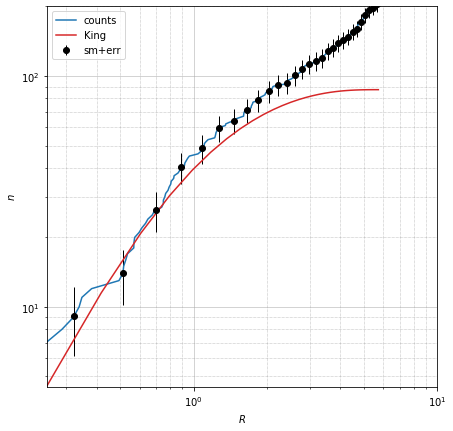

In [13]:
final_output = 0

show_plot=1
log_prob(mean_X + 0*std_X)
show_plot=0

In [14]:
import time

start = time.time()
ni=12
for j in range(ni):
    lf=log_prob(p0[j])
end = time.time()
print((end - start)/ni)


0.004244506359100342


In [15]:
import emcee
from multiprocessing import Pool

pool = Pool(processes=int(Nwalkers/4))
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, log_prob, pool=pool)

In [16]:
# Burn-in
start = time.time()
state = sampler.run_mcmc(p0, 100)
sampler.reset()
end = time.time()
print(end - start)

1.4900360107421875


In [17]:
# MCMC call

max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(state, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 20%|██        | 20200/100000 [05:25<21:26, 62.03it/s]


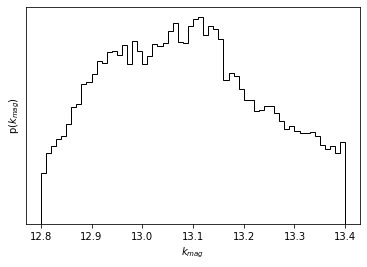

In [18]:
#  Show individual distributions
#  rt,    rc,     k,   RA_0,   dec_0,   kmag

j=5
samples = sampler.get_chain(flat=True)
plt.hist(samples[:,j], 60, color="k", histtype="step")
plt.xlabel(labels[j])
plt.ylabel(r"p(" + labels[j] +r")")
plt.gca().set_yticks([]);

In [19]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.352


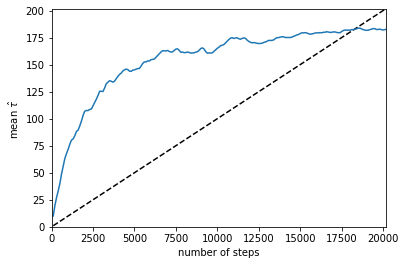

In [20]:
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

burn-in: 403
thin: 85
flat chain shape: (2784, 6)
flat log prob shape: (2784,)


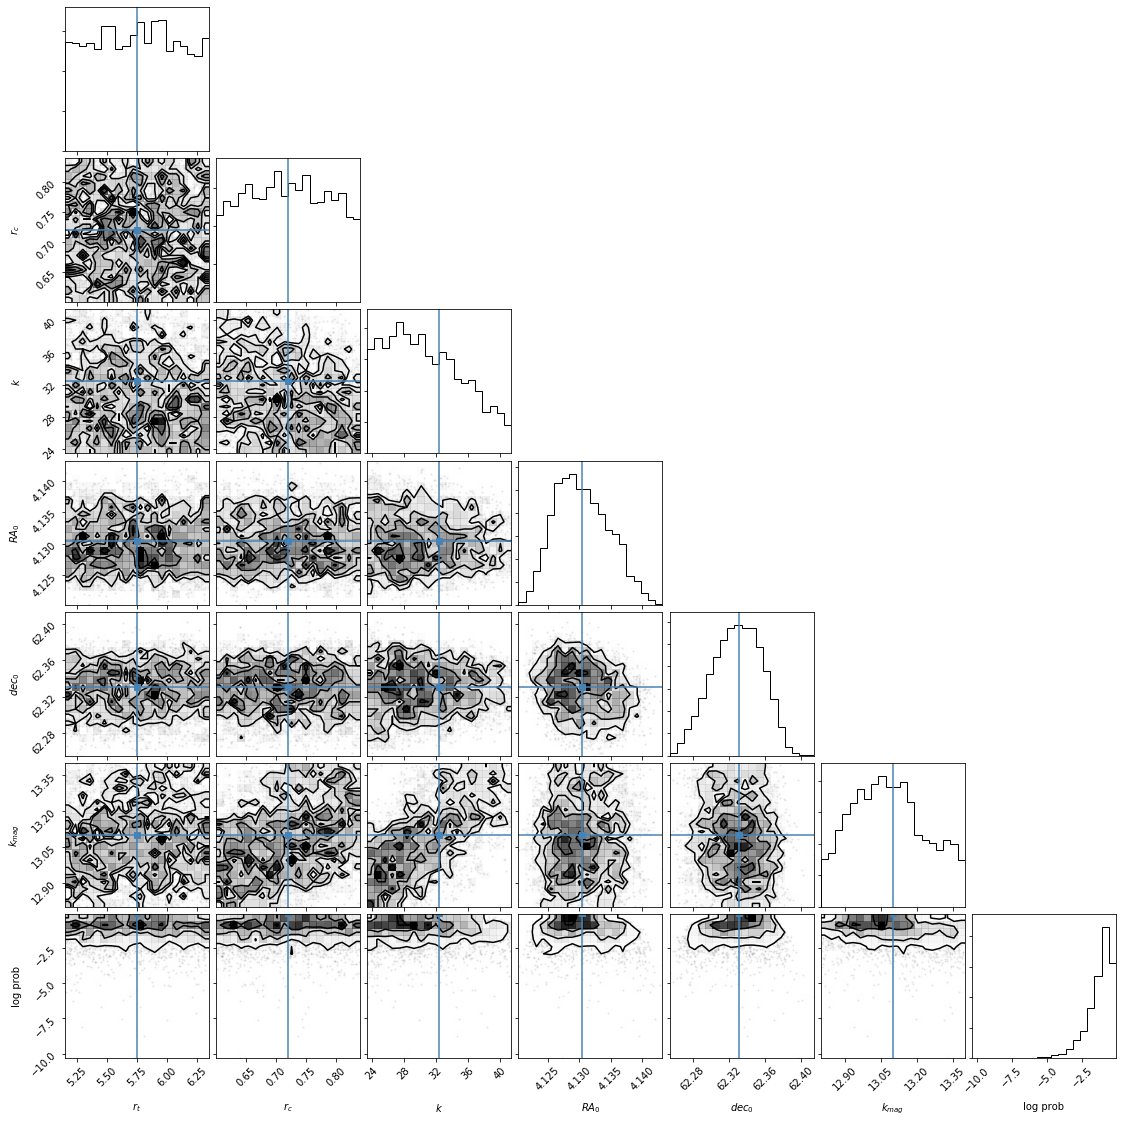

In [23]:
# Corner diagram

import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

'''
all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)
'''

# labels = list(map(r"$\theta_{{{0}}}$".format, range(1, Ndim + 1)))

corner.corner(all_samples, labels=labels, truths=np.append(mean_X[:], np.array([0.0])) );

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

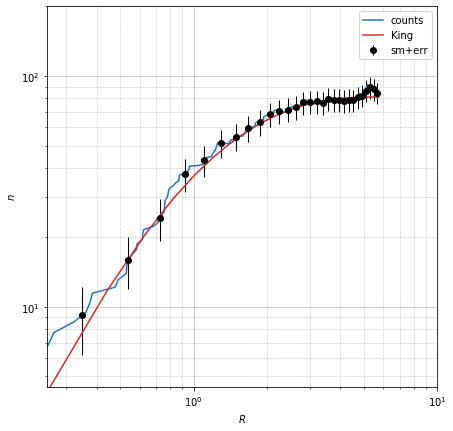

In [24]:
from IPython.display import display, Math

X_opt = np.zeros( Ndim, dtype=np.float )

for i in range(Ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    X_opt[i] = mcmc[1]
    
final_output = 1
show_plot = 1
log_prob(X_opt)
show_plot = 0

In [25]:
for i in range(Ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{0:7.3f}    -{1:6.3f}    {2:6.3f}"
    txt = txt.format(mcmc[1], q[0], q[1])
    display(txt)

'  5.754    - 0.405     0.385'

'  0.719    - 0.078     0.078'

' 30.158    - 4.440     6.088'

'  4.130    - 0.004     0.005'

' 62.330    - 0.030     0.027'

' 13.076    - 0.151     0.181'